In [120]:
len(stopwords)

746

In [122]:
import numpy as np 
import pandas as pd 

def get_data(data_file_path):
    lines = [] #經斷詞處理的簡訊
    labels = [] #標籤結果
    for line in open(data_file_path, "r", encoding="utf-8"):
        arr = line.rstrip().split("\t")
        if len(arr) < 3: #資料集應有三欄，若小於三欄判斷為缺失資料，將其跳過
            continue 
        if int(arr[0]) == 1:
            label = 1
        elif int(arr[0]) == 0 or int(arr[0]) == -1:
            label = 0
        else:
            continue
        labels.append(label)
        line = arr[2].split()
        lines.append(line)
    return lines, labels


def create_vocab_dict(data_lines):
    vocab_dict = {}
    for data_line in data_lines:
        for word in data_line:
            if word in vocab_dict:
                vocab_dict[word] += 1 #如字典裡已經有該詞，出現次數+1
            else:
                vocab_dict[word] = 1 #如字典裡沒有該詞，將出現次數初始化設定為1
    return vocab_dict


def BOW_feature(vocab_list, input_line):
    return_vec = np.zeros(len(vocab_list), )
    for word in input_line:
        if word in vocab_list:
            return_vec[vocab_list.index(word)] += 1 #如果簡訊內包含字典內的詞彙，根據詞彙id標記出現次數+1
    return return_vec


if __name__ == "__main__":

    train_file_path = "mudou_spam_train.txt"
    test_file_path = "mudou_spam_test.txt"

    train_data, train_label = get_data(train_file_path)
    test_data, test_label = get_data(test_file_path)


    vocab_dict = create_vocab_dict(train_data)
    sorted_vocab_list = sorted(vocab_dict.items(), key=lambda d:d[1], reverse=True)
    min_freq = 5
    vocab_list = [v[0] for v in sorted_vocab_list if int(v[1]) > min_freq]
    vocab_list = [v for v in vocab_list if v not in stopwords]
   
    train_X = []
    for one_msg in train_data:
        train_X.append(BOW_feature(vocab_list, one_msg))


    test_X = []
    for one_msg in test_data:
        test_X.append(BOW_feature(vocab_list, one_msg))

    train_X = np.array(train_X)
    test_X = np.array(test_X)
    train_label = np.array(train_label)
    test_label = np.array(test_label)
    with open('train_X.npy', 'wb') as tr_X:
        np.save(tr_X, train_X)
    with open('test_X.npy', 'wb') as te_X:
        np.save(te_X, test_X)
    with open('train_label.npy', 'wb') as tr_y:
        np.save(tr_y, train_label)
    with open('test_label.npy', 'wb') as te_y:
        np.save(te_y, test_label)

In [121]:
stopwords = []
for stopword in open('cn_stopwords.txt', "r", encoding="utf-8"):
    stopwords.append(stopword.split('\n')[0])
vocab_list = [v for v in vocab_list if v not in stopwords]

In [126]:
train_X.shape

(10832, 5759)

In [46]:
with open('train_X.npy', 'rb') as tr_X:
  train_X = np.load(tr_X,allow_pickle=True)
with open('test_X.npy', 'rb') as te_X:
  test_X = np.load(te_X,allow_pickle=True)
with open('train_label.npy', 'rb') as tr_y:
  train_label = np.load(tr_y,allow_pickle=True)
with open('test_label.npy', 'rb') as te_y:
  test_label = np.load(te_y,allow_pickle=True)

資料分布    

|     |ham (0) |spam (1)|total|
|-----|--------|--------|-----|
|train|3933    |6899    |10832|
|test |491     |888     |1379 |  

In [95]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
resampled_X, resampled_label = rus.fit_resample(train_X,train_label)

In [125]:
resampled_X.shape

(7866, 50)

In [62]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
train_unique, train_counts = np.unique(train_label, return_counts=True)
print(train_unique, train_counts)
test_unique, test_counts = np.unique(test_label, return_counts=True)
print(test_unique, test_counts)

train_X_, val_X, train_label_, val_label = train_test_split(train_X, train_label, test_size=.2, stratify=train_label, random_state=42)
train_unique, train_counts = np.unique(train_label_, return_counts=True)
print(train_unique, train_counts)
val_unique, val_counts = np.unique(val_label, return_counts=True)
print(val_unique, val_counts)


[0 1] [3933 6899]
[0 1] [491 888]
[0 1] [3146 5519]
[0 1] [ 787 1380]


In [127]:
from sklearn.linear_model import LogisticRegression
reg_model = LogisticRegression(max_iter=1000)
reg_model.fit(train_X, train_label)
reg_y_pred = reg_model.predict(test_X)

train_acc = reg_model.score(train_X, train_label)
print("Train accuracy: ", train_acc)
test_acc = reg_model.score(test_X, test_label)
print("Test accuracy: ", test_acc)

pred_prob_y = reg_model.predict_proba(test_X)[:, 1]
reg_loss = metrics.log_loss(test_label, pred_prob_y)
print("Test Cross Entropy Loss: ", reg_loss)

Train accuracy:  0.9919682422451994
Test accuracy:  0.9651921682378535
Test Cross Entropy Loss:  0.1176503895005528


In [64]:
from sklearn.tree import DecisionTreeClassifier
max_dep = 15
best_max_dep = 15
min_loss = 10
while max_dep > 5:
  dt_model = DecisionTreeClassifier(max_depth = max_dep)
  dt_model.fit(train_X_, train_label_)
  pred_prob_y = dt_model.predict_proba(val_X)[:, 1]
  current_loss = metrics.log_loss(val_label, pred_prob_y)
  if current_loss < min_loss:
    min_loss = current_loss
    best_max_dep = max_dep
  max_dep -= 1
print("Best Max Depth: ", best_max_dep)
print("Min Cross Entropy Loss: ", min_loss)

Best Max Depth:  10
Min Cross Entropy Loss:  0.4293096367112812


In [128]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth = 10)
dt_model.fit(train_X, train_label)
dt_y_pred = dt_model.predict(test_X)

train_acc = dt_model.score(train_X, train_label)
print("Train accuracy: ", train_acc)
test_acc = dt_model.score(test_X, test_label)
print("Test accuracy: ", test_acc)

pred_prob_y = dt_model.predict_proba(test_X)[:, 1]
dt_loss = metrics.log_loss(test_label, pred_prob_y)
print("Test Cross Entropy Loss: ", dt_loss)

Train accuracy:  0.8509047267355982
Test accuracy:  0.8339376359680928
Test Cross Entropy Loss:  0.45621561548491285


In [129]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(train_X, train_label)
rf_y_pred = rf_model.predict(test_X)

train_acc = rf_model.score(train_X, train_label)
print("Train accuracy: ", train_acc)
test_acc = rf_model.score(test_X, test_label)
print("Test accuracy: ", test_acc)

pred_prob_y = rf_model.predict_proba(test_X)[:, 1]
rf_loss = metrics.log_loss(test_label, pred_prob_y)
print("Test Cross Entropy Loss: ", rf_loss)

Train accuracy:  0.9987075332348597
Test accuracy:  0.9644670050761421
Test Cross Entropy Loss:  0.12767904744708955


In [130]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(train_X, train_label)
nb_y_pred = nb_model.predict(test_X)

train_acc = nb_model.score(train_X, train_label)
print("Train accuracy: ", train_acc)
test_acc = nb_model.score(test_X, test_label)
print("Test accuracy: ", test_acc)

pred_prob_y = nb_model.predict_proba(test_X)[:, 1]
nb_loss = metrics.log_loss(test_label, pred_prob_y)
print("Test Cross Entropy Loss: ", nb_loss)

Train accuracy:  0.9572562776957164
Test accuracy:  0.9274836838288615
Test Cross Entropy Loss:  2.5046416445370157


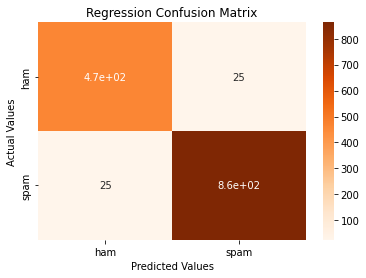

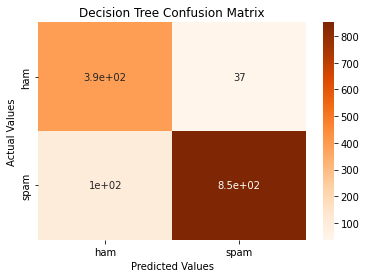

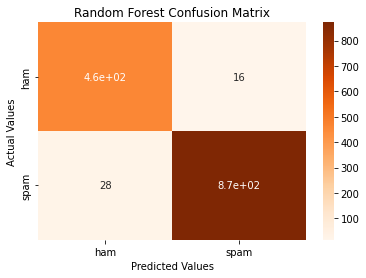

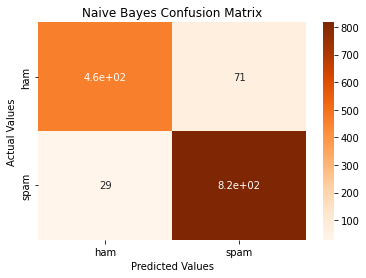

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

reg_confusion_matrix = metrics.confusion_matrix(reg_y_pred,test_label)
reg_cm = sns.heatmap(reg_confusion_matrix, annot=True, cmap='Oranges')
reg_cm.set_title('Regression Confusion Matrix')
reg_cm.set_xlabel('Predicted Values')
reg_cm.set_ylabel('Actual Values')
reg_cm.xaxis.set_ticklabels(['ham','spam'])
reg_cm.yaxis.set_ticklabels(['ham','spam'])
plt.show()

dt_confusion_matrix = metrics.confusion_matrix(dt_y_pred,test_label)
dt_cm = sns.heatmap(dt_confusion_matrix, annot=True, cmap='Oranges')
dt_cm.set_title('Decision Tree Confusion Matrix')
dt_cm.set_xlabel('Predicted Values')
dt_cm.set_ylabel('Actual Values')
dt_cm.xaxis.set_ticklabels(['ham','spam'])
dt_cm.yaxis.set_ticklabels(['ham','spam'])
plt.show()

rf_confusion_matrix = metrics.confusion_matrix(rf_y_pred,test_label)
rf_cm = sns.heatmap(rf_confusion_matrix, annot=True, cmap='Oranges')
rf_cm.set_title('Random Forest Confusion Matrix')
rf_cm.set_xlabel('Predicted Values')
rf_cm.set_ylabel('Actual Values')
rf_cm.xaxis.set_ticklabels(['ham','spam'])
rf_cm.yaxis.set_ticklabels(['ham','spam'])
plt.show()

nb_confusion_matrix = metrics.confusion_matrix(nb_y_pred,test_label)
nb_cm = sns.heatmap(nb_confusion_matrix, annot=True, cmap='Oranges')
nb_cm.set_title('Naive Bayes Confusion Matrix')
nb_cm.set_xlabel('Predicted Values')
nb_cm.set_ylabel('Actual Values')
nb_cm.xaxis.set_ticklabels(['ham','spam'])
nb_cm.yaxis.set_ticklabels(['ham','spam'])
plt.show()

In [54]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=42)
mlp_model.fit(resampled_X, resampled_label)
mlp_y_pred = mlp_model.predict(test_X)

train_acc = mlp_model.score(train_X, train_label)
print("Train accuracy: ", train_acc)
test_acc = mlp_model.score(test_X, test_label)
print("Test accuracy: ", test_acc)

pred_prob_y = mlp_model.predict_proba(test_X)[:, 1]
mlp_loss = metrics.log_loss(test_label, pred_prob_y)
print("Test Cross Entropy Loss: ", mlp_loss)

Train accuracy:  0.9861521418020679
Test accuracy:  0.9601160261058739
Test Cross Entropy Loss:  0.6562899350222454


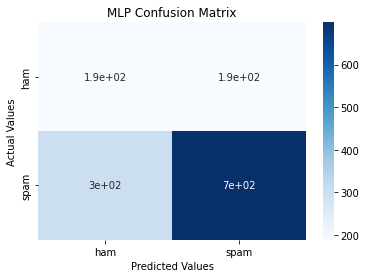

In [86]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
mlp_confusion_matrix = metrics.confusion_matrix(mlp_y_pred,test_label)
mlp_cm = sns.heatmap(mlp_confusion_matrix, annot=True, cmap='Blues')
mlp_cm.set_title('MLP Confusion Matrix')
mlp_cm.set_xlabel('Predicted Values')
mlp_cm.set_ylabel('Actual Values')
mlp_cm.xaxis.set_ticklabels(['ham','spam'])
mlp_cm.yaxis.set_ticklabels(['ham','spam'])
plt.show()

In [111]:
import numpy as np 
import pandas as pd 

def get_data(data_file_path):
    
    lines = []    
    labels = []
    
    for line in open(data_file_path, "r", encoding="utf-8"):

        arr = line.rstrip().split("\t")
        if len(arr) < 3:
            continue
        
        if int(arr[0]) == 1:
            label = 1
        elif int(arr[0]) == 0 or int(arr[0]) == -1:
            label = 0
        else:
            continue
        labels.append(label)
        
        line = arr[2].split()
        lines.append(line)
        
    return lines, labels


def create_vocab_dict(data_lines,label):
    vocab_dict = {}
    for data_line in data_lines:
      for word in data_line:
        if word not in vocab_dict:
            vocab_dict[word] = 0
        vocab_dict[word] += 1*label[data_lines.index(data_line)] #只考慮詞彙在spam message的出現次數
    return vocab_dict


def sequence_feature(vocab_dict, input_line):
    return_vec = []
    for word in input_line:
        if word in vocab_dict:
            return_vec.append(vocab_dict[word])
        else:
            return_vec.append(0)
    return return_vec


train_file_path = "mudou_spam_train.txt"
test_file_path = "mudou_spam_test.txt"

train_data, train_label = get_data(train_file_path)
test_data, test_label = get_data(test_file_path)


vocab_dict = create_vocab_dict(train_data,train_label)
print(len(vocab_dict))
vocab_dict = {key:val for key, val in vocab_dict.items() if val > 5}
print(len(vocab_dict))


32450
4632


NameError: ignored

In [112]:
vocab_dict = {key:val for key, val in vocab_dict.items() if key not in stopwords}
print(len(vocab_dict))

4412


In [113]:
train_X = []
for one_msg in train_data:
    train_X.append(sequence_feature(vocab_dict, one_msg))

test_X = []
for one_msg in test_data:
    test_X.append(sequence_feature(vocab_dict, one_msg))

train_X = np.array(train_X)
test_X = np.array(test_X)
train_label = np.array(train_label)
test_label = np.array(test_label)
with open('n_train_X.npy', 'wb') as tr_X:
    np.save(tr_X, train_X)
with open('n_test_X.npy', 'wb') as te_X:
    np.save(te_X, test_X)
with open('n_train_label.npy', 'wb') as tr_y:
    np.save(tr_y, train_label)
with open('n_test_label.npy', 'wb') as te_y:
    np.save(te_y, test_label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [114]:
import numpy as np 
with open('n_train_X.npy', 'rb') as tr_X:
  train_X = np.load(tr_X,allow_pickle=True)
with open('n_test_X.npy', 'rb') as te_X:
  test_X = np.load(te_X,allow_pickle=True)
with open('n_train_label.npy', 'rb') as tr_y:
  train_label = np.load(tr_y,allow_pickle=True)
with open('n_test_label.npy', 'rb') as te_y:
  test_label = np.load(te_y,allow_pickle=True)

In [115]:
from tensorflow.keras.preprocessing import sequence
train_X = sequence.pad_sequences(train_X, maxlen=50)
test_X = sequence.pad_sequences(test_X, maxlen=50)

In [117]:
train_X.shape

(10832, 50)

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

In [102]:
rnn_model = Sequential()
rnn_model.add(Embedding(10832, 128))
rnn_model.add(LSTM(128))
rnn_model.add(Dropout(0.3)) # 增加Dropout層，防止過擬和
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 128)         1386496   
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,518,209
Trainable params: 1,518,209
Non-trainable params: 0
_________________________________________________________________


In [118]:
from keras.callbacks import EarlyStopping   # 利用Early Stopping方法節省訓練時間，如果在3個epoch內沒提升模型表現就提前終止訓練（防止花了時間訓練卻過擬和）
from keras.callbacks import ModelCheckpoint # 利用Model Checkpoint將目前為止訓練的最佳模型暫存起來

callback = [EarlyStopping(monitor='loss', patience=3, mode='min'),
            ModelCheckpoint(filepath='rnn_best_model.h5', monitor='loss', save_best_only=True)]
history = rnn_model.fit(train_X, train_label, batch_size=128, epochs=10, callbacks=[callback])

Epoch 1/10
85/85 [==============================] - 2s 10ms/step - loss: 0.1795 - accuracy: 0.9301
Epoch 2/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1483 - accuracy: 0.9432
Epoch 3/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1388 - accuracy: 0.9483
Epoch 4/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1323 - accuracy: 0.9510
Epoch 5/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1281 - accuracy: 0.9523
Epoch 6/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1196 - accuracy: 0.9557
Epoch 7/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1146 - accuracy: 0.9554
Epoch 8/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1112 - accuracy: 0.9583
Epoch 9/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1058 - accuracy: 0.9595
Epoch 10/10
85/85 [==============================] - 1s 10ms/step - loss: 0.1005 - accuracy: 0.9626


44/44 [==============================] - 1s 4ms/step - loss: 0.2025 - accuracy: 0.9289
Test accuracy:  0.9289340376853943
Test loss:  0.2024720460176468


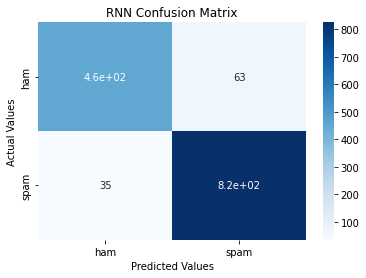

In [119]:
# 模型準確度
import matplotlib.pyplot as plt
import seaborn as sns

rnn_model = tf.keras.models.load_model('rnn_best_model.h5')
rnn_pred = rnn_model.predict(test_X)
rnn_y_pred = np.array([])
for pred in rnn_pred:
  rnn_y_pred = np.append(rnn_y_pred, round(pred[0]))
results = rnn_model.evaluate(test_X, test_label)
print("Test accuracy: ", results[1])
print("Test loss: ", results[0])

rnn_confusion_matrix = metrics.confusion_matrix(rnn_y_pred,test_label)
rnn_cm = sns.heatmap(rnn_confusion_matrix, annot=True, cmap='Blues')
rnn_cm.set_title('RNN Confusion Matrix')
rnn_cm.set_xlabel('Predicted Values')
rnn_cm.set_ylabel('Actual Values')
rnn_cm.xaxis.set_ticklabels(['ham','spam'])
rnn_cm.yaxis.set_ticklabels(['ham','spam'])
plt.show()


In [83]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
input_shape=(677,16,6012)
cnn_model = Sequential()
cnn_model.add(Conv1D(32,1, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_model.build(input_shape)
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (677, 16, 32)             192416    
                                                                 
 dense_11 (Dense)            (677, 16, 128)            4224      
                                                                 
 dense_12 (Dense)            (677, 16, 1)              129       
                                                                 
Total params: 196,769
Trainable params: 196,769
Non-trainable params: 0
_________________________________________________________________


In [7]:
train_X=np.reshape(train_X,(677,16,6012))
train_label=np.reshape(train_label,(677,16,1))

In [8]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
callback = [EarlyStopping(monitor='val_loss', patience=3, mode='min'),
            ModelCheckpoint(filepath='cnn_best_model.h5', monitor='val_loss', save_best_only=True,)]
history = cnn_model.fit(train_X, train_label, batch_size=1, epochs=10, callbacks=[callback])

Epoch 1/10
677/677 [==============================] - 14s 3ms/step - loss: 0.1776 - accuracy: 0.9291
Epoch 2/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0489 - accuracy: 0.9840
Epoch 3/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0174 - accuracy: 0.9942
Epoch 4/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0081 - accuracy: 0.9977
Epoch 5/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0049 - accuracy: 0.9989
Epoch 6/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0038 - accuracy: 0.9991
Epoch 7/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0031 - accuracy: 0.9992
Epoch 8/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0099 - accuracy: 0.9990
Epoch 9/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0129 - accuracy: 0.9954
Epoch 10/10
677/677 [==============================] - 2s 3ms/step - loss: 0.0058 - accuracy: 0.998

In [41]:
# 模型準確度
import matplotlib.pyplot as plt
import seaborn as sns
test_X=np.reshape(test_X[:1376,:],(86,16,6012))
test_label=np.reshape(test_label[:1376],(86,16,1))
cnn_model = tf.keras.models.load_model('cnn_best_model.h5')
cnn_y_pred = cnn_model.predict(test_X)
# cnn_y_pred = np.array([])
# for pred in cnn_pred:
#   cnn_y_pred = np.append(cnn_y_pred, round(pred[0]))
results = cnn_model.evaluate(test_X, test_label)
print("Test accuracy: ", results[1])
print("Test loss: ", results[0])

3/3 [==============================] - 0s 9ms/step - loss: 0.3267 - accuracy: 0.9564
Test accuracy:  0.9563953280448914
Test loss:  0.3266580402851105


In [38]:
cnn_y_pred_ = np.array([])
for i in cnn_y_pred:
  num = round(i[0])
  cnn_y_pred_=np.append(cnn_y_pred_,np.array([num]))

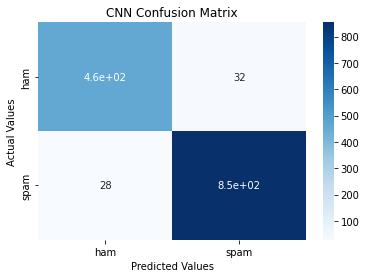

In [42]:
from sklearn import metrics
cnn_y_pred = np.reshape(cnn_y_pred,(1376,1))
test_label = np.reshape(test_label,(1376,1))
cnn_confusion_matrix = metrics.confusion_matrix(cnn_y_pred_,test_label)
cnn_cm = sns.heatmap(cnn_confusion_matrix, annot=True, cmap='Blues')
cnn_cm.set_title('CNN Confusion Matrix')
cnn_cm.set_xlabel('Predicted Values')
cnn_cm.set_ylabel('Actual Values')
cnn_cm.xaxis.set_ticklabels(['ham','spam'])
cnn_cm.yaxis.set_ticklabels(['ham','spam'])
plt.show()